# Other dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("data/Evaluation of three potential ML algorithms - train-test.csv")
data

,Wind speed,Thrust coefficient,s (x/D),r,r/R,Velocity,TKE,TI,TI(%)
0,7,0.536453,0.5,0.000000,0.000000,6.881098,0.041220,0.024091,2.409070
1,7,0.536453,0.5,0.151515,0.030128,6.871302,0.042116,0.024386,2.438600
2,7,0.536453,0.5,0.303030,0.060257,6.819288,0.042842,0.024783,2.478289
3,7,0.536453,0.5,0.454545,0.090385,6.767278,0.043568,0.025184,2.518408
4,7,0.536453,0.5,0.606061,0.120513,6.714196,0.044380,0.025619,2.561856
...,...,...,...,...,...,...,...,...,...
10395,22,0.142007,12.5,14.393930,2.862185,22.023577,0.000188,0.000509,0.050929
10396,22,0.142007,12.5,14.545445,2.892314,22.023737,0.000176,0.000492,0.049230
10397,22,0.142007,12.5,14.696960,2.922442,22.023876,0.000165,0.000477,0.047710
10398,22,0.142007,12.5,14.848475,2.952570,22.023998,0.000156,0.000463,0.046316


In [2]:
Xs = data["s (x/D)"].unique()
Ys = data["r"].unique()
shape = len(Xs), len(Ys)
shape

(17, 198)

In [3]:
X_LABEL = 's (x/D)'
Y_LABEL = 'r' # or 'r/R
Z_LABEL = 'Velocity'
GROUPBY = 'Wind speed'

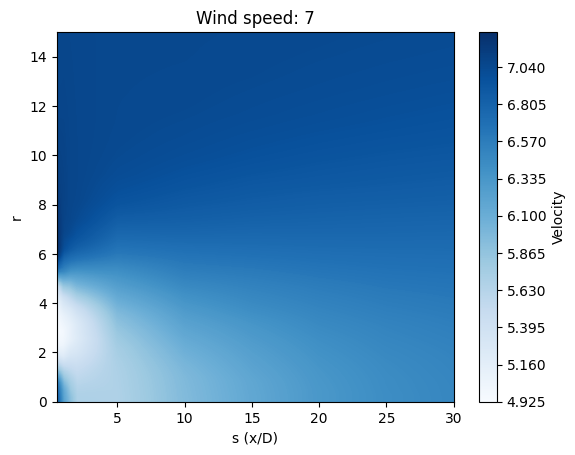

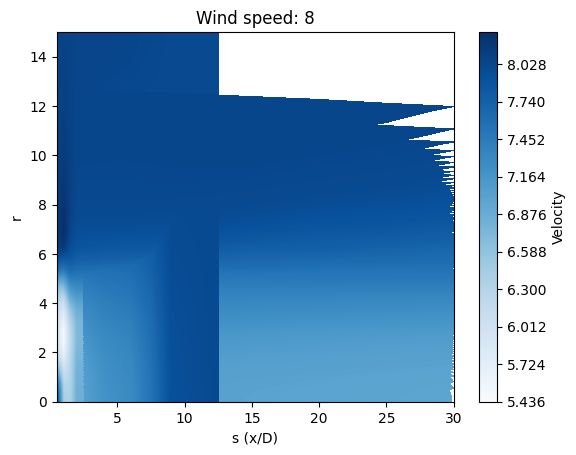

KeyboardInterrupt: 

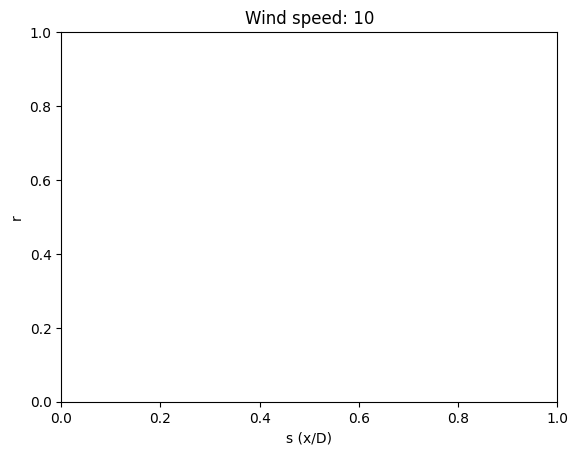

In [4]:
def plot_contour(X, Y, Z,
                   xlabel: str, ylabel: str, zlabel: str, title: str,
                   levels = 500, cmap: str = "Blues", ax = None) -> None:
    ax = plt.gca()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    c = ax.contourf(X, Y, Z, levels=levels, cmap=cmap)
    plt.colorbar(c, label=zlabel, ax=ax)
    plt.show()

for wind_speed, subdf in data.groupby(GROUPBY):
    assert not subdf[[X_LABEL, Y_LABEL]].duplicated().any()
    X, Y = np.meshgrid(subdf[X_LABEL].unique(), subdf[Y_LABEL].unique())
    Z = subdf.pivot(index=Y_LABEL, columns=X_LABEL, values="Velocity").values
    plot_contour(X, Y, Z, X_LABEL, Y_LABEL, Z_LABEL, title=f"Wind speed: {wind_speed}")

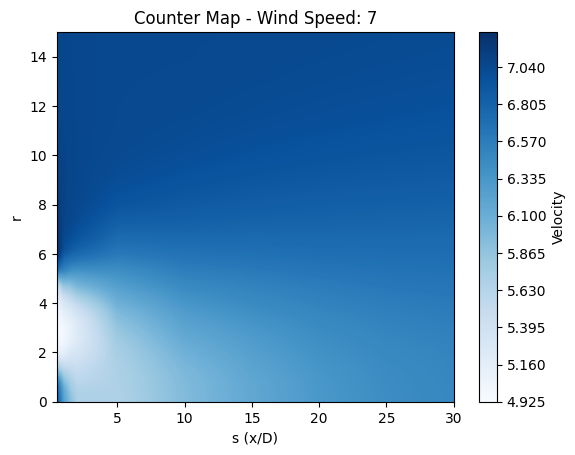

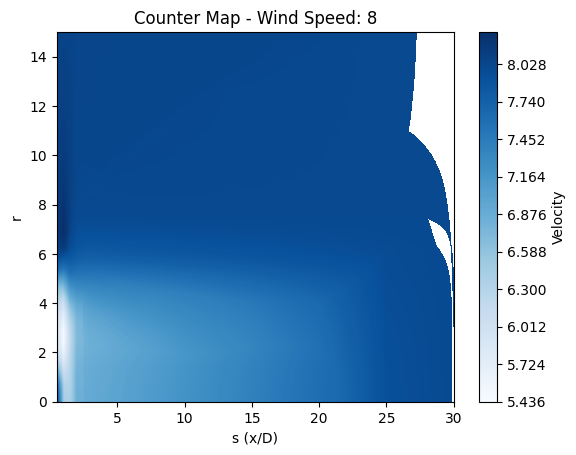

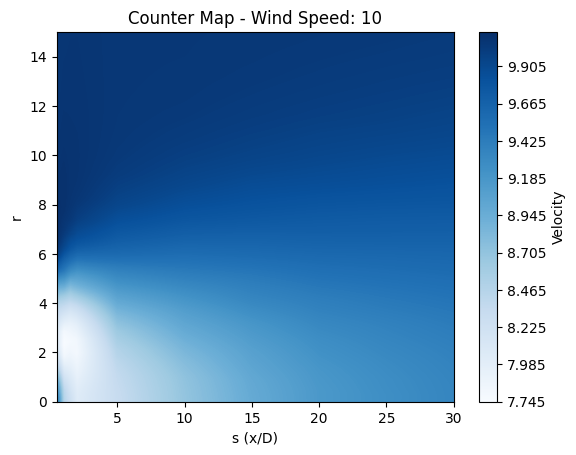

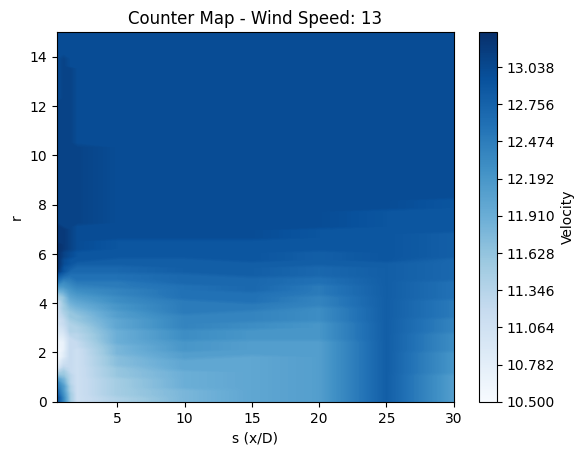

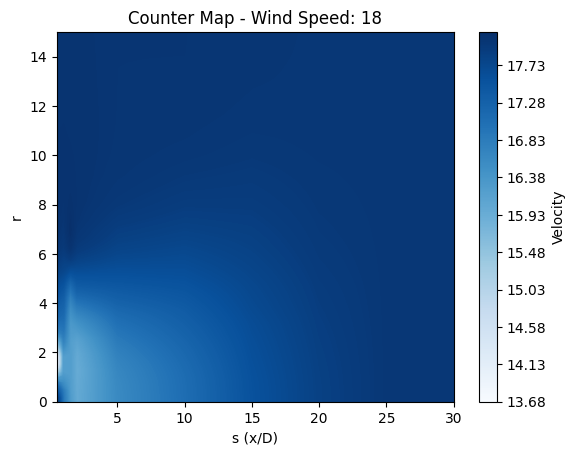

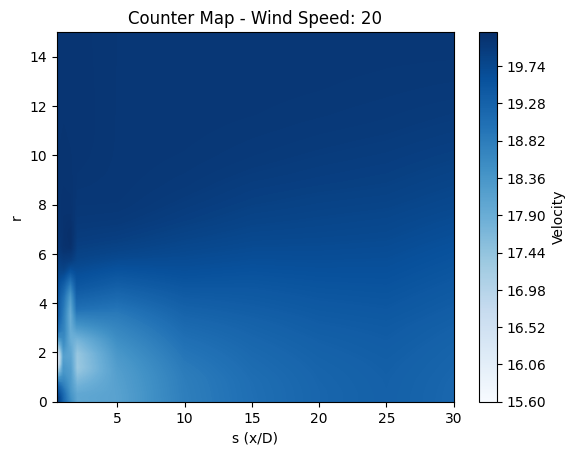

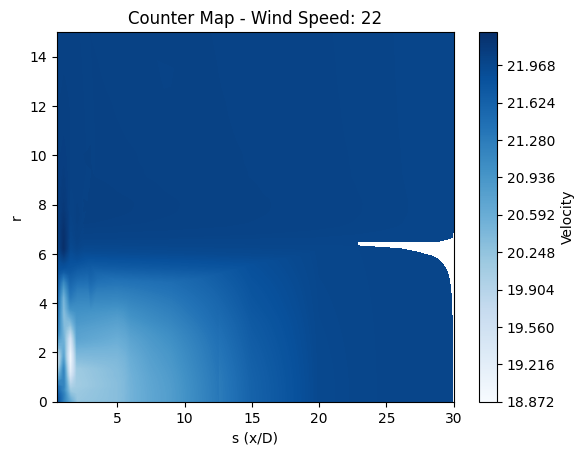

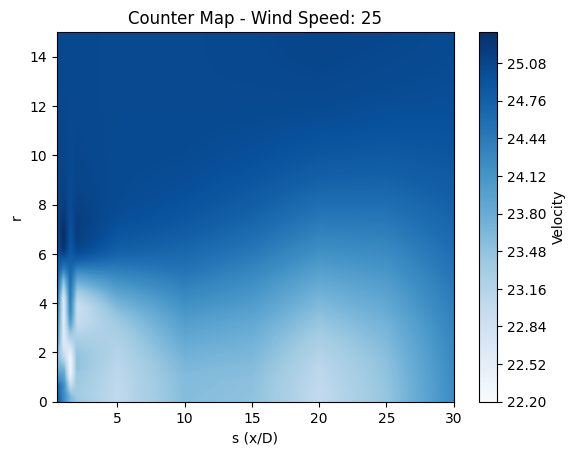

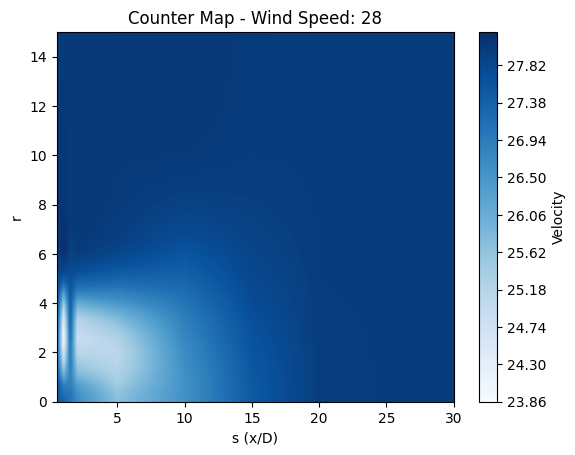

In [ ]:
for wind_speed, subdf in data.groupby(GROUPBY):
    s_values = subdf[X_LABEL]
    r_values = subdf[Y_LABEL]
    velocity_values = subdf[Z_LABEL]

    X, Y = np.meshgrid(s_values.unique(), r_values.unique())

    # Create an empty 2D array for counter values
    counter_values = np.zeros_like(X)

    # Fill the counter values array with corresponding velocity values
    for s, r, velocity in zip(s_values, r_values, velocity_values):
        s_index = np.where(X[0] == s)[0][0]
        r_index = np.where(Y[:, 0] == r)[0][0]
        counter_values[r_index, s_index] = velocity

    plot_contour(X, Y, counter_values, X_LABEL, Y_LABEL, Z_LABEL, title=f'Counter Map - Wind Speed: {wind_speed}')


# Time comparison between pywake and my model simulations

In [ ]:
import utils.utils as utils
import xarray as xr
import time
import itertools
import torch
import torch.nn as nn
import numpy as np

from py_wake.deficit_models import EddyViscosityModel

import utils.utils as utils
import utils.pywake_utils as py_wake_utils
import utils.data_utils as data_utils

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# default parameters
TURBINE_X = [0]
TURBINE_Y = [0]
WIND_DIRECTION = 270 

# IEA37 values
TURBINE_DIAMETER = 198
TURBINE_HUB_HEIGHT = 119
TURBINE_POWER_NORM = 10000

# discretization factors
X_START_FACTOR = 2
X_END_FACTOR = 20
Y_START_FACTOR = -5
Y_END_FACTOR = 5
GRID_STEP_FACTOR = 1/8

# parameters for data generation
WS_RANGE = range(3, 26)
# TODO change the step sizes?
TI_STEP = 0.01
CT_STEP = 0.01
TIs = utils.my_arange(0, 1, TI_STEP)
CTs = utils.my_arange(0.2, 24/25, CT_STEP)

In [ ]:
horizontal_grid = py_wake_utils.get_discretized_grid(TURBINE_DIAMETER,
                                       X_START_FACTOR, X_END_FACTOR, Y_START_FACTOR, Y_END_FACTOR,
                                       GRID_STEP_FACTOR)

ws_to_list = dict()
for wind_speed in WS_RANGE:
    datasets = list()

    start_time = time.time()

    for ti, ct in itertools.product(TIs, CTs):
        site = py_wake_utils.get_site(ti=ti, ws=wind_speed)
        wind_turbine = py_wake_utils.get_wind_turbine(TURBINE_DIAMETER, TURBINE_HUB_HEIGHT, TURBINE_POWER_NORM,
                                        constant_ct=ct, ti=ti)
        
        # single wake model
        ainslie_model = EddyViscosityModel(site, wind_turbine)

        ds = py_wake_utils.generate_wake_dataset(ainslie_model, wind_speed, WIND_DIRECTION,
                                    TURBINE_DIAMETER, TURBINE_X, TURBINE_Y,
                                    horizontal_grid, wind_turbine)
        datasets.append(ds)

    filepath = data_utils.get_filepath(X_START_FACTOR, X_END_FACTOR, Y_START_FACTOR, Y_END_FACTOR,
                                  GRID_STEP_FACTOR, wind_speed, TI_STEP, CT_STEP)
    final_ds = xr.concat([d.stack(z=['x:D', 'y:D', 'ti', 'ct']) for d in datasets], 'z').unstack('z')
    cacca = final_ds.load()
    
    end_time = time.time()
    execution_time = end_time - start_time
    num_simulations = len(datasets)
    print(f"For {wind_speed=}] Execution time: {execution_time} seconds for {num_simulations} simulations -> {(execution_time/num_simulations):2f}s per simulation")
    ws_to_list[wind_speed] = [num_simulations, execution_time]

tot_simulations = sum([num_sim for num_sim, _ in ws_to_list.values()])
tot_time = sum([ex_time for _, ex_time in ws_to_list.values()])
print(f"\nOverall execution time for {tot_simulations} simulations: {tot_time} seconds -> {tot_time/tot_simulations:2f}s per simulation")


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


For wind_speed=3] Execution time: 8515.641827106476 seconds for 7600 simulations -> 1.120479s per simulation


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


For wind_speed=4] Execution time: 8498.752365112305 seconds for 7600 simulations -> 1.118257s per simulation


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


For wind_speed=5] Execution time: 8514.600550889969 seconds for 7600 simulations -> 1.120342s per simulation


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


For wind_speed=6] Execution time: 8463.694307804108 seconds for 7600 simulations -> 1.113644s per simulation


KeyboardInterrupt: 

In [ ]:
MODEL_PATH = "saved_models/discr_factors_x2_20_y-5_5_step0.125_TIstep0.01_CTstep0.01/multivariate_NN_layers50-500-2500.pt"
HIDDEN_LAYERS_UNITS = [int(lu) for lu in MODEL_PATH.split("layers")[-1].split(".pt")[0].split("-")]

class MultivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(MultivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS + [output_space]
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), nn.ReLU()]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

model = MultivariateNN(2, 11520)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ws_to_list = dict()
with torch.no_grad():
    for wind_speed in WS_RANGE:
        datasets = list()

        start_time = time.time()

        for ti, ct in itertools.product(TIs, CTs):
            wake_field = model(torch.FloatTensor([ti, ct]))
            datasets.append(wake_field)

        end_time = time.time()
        execution_time = end_time - start_time
        num_simulations = len(datasets)
        print(f"For {wind_speed=}] Execution time: {execution_time} seconds for {num_simulations} simulations -> {(execution_time/num_simulations):2f}s per simulation")
        ws_to_list[wind_speed] = [num_simulations, execution_time]

tot_simulations = sum([num_sim for num_sim, _ in ws_to_list.values()])
tot_time = sum([ex_time for _, ex_time in ws_to_list.values()])
print(f"\nOverall execution time for {tot_simulations} simulations: {tot_time} seconds -> {tot_time/tot_simulations:2f}s per simulation")

For wind_speed=3] Execution time: 28.539746046066284 seconds for 7600 simulations -> 0.003755s per simulation
For wind_speed=4] Execution time: 28.614805936813354 seconds for 7600 simulations -> 0.003765s per simulation
For wind_speed=5] Execution time: 29.45336079597473 seconds for 7600 simulations -> 0.003875s per simulation
For wind_speed=6] Execution time: 28.728474140167236 seconds for 7600 simulations -> 0.003780s per simulation
For wind_speed=7] Execution time: 29.862894773483276 seconds for 7600 simulations -> 0.003929s per simulation
For wind_speed=8] Execution time: 29.59728980064392 seconds for 7600 simulations -> 0.003894s per simulation
For wind_speed=9] Execution time: 29.345993041992188 seconds for 7600 simulations -> 0.003861s per simulation
For wind_speed=10] Execution time: 29.615293979644775 seconds for 7600 simulations -> 0.003897s per simulation
For wind_speed=11] Execution time: 29.477768898010254 seconds for 7600 simulations -> 0.003879s per simulation
For wind_s

# Input parameters tuning

In [ ]:
import random
import utils.plotting

DEFICIT_THRESHOLD = 1/100 #putting it to 1/1000, the region becomes too big

X_START_FACTOR = 2
X_END_FACTOR = 50
Y_START_FACTOR = -10
Y_END_FACTOR = 10

horizontal_grid = py_wake_utils.get_discretized_grid(TURBINE_DIAMETER,
                                       X_START_FACTOR, X_END_FACTOR, Y_START_FACTOR, Y_END_FACTOR,
                                       GRID_STEP_FACTOR)

x_ranges = list()
y_ranges = list()

for wind_speed in random.sample(list(WS_RANGE), 5):
    for ti, ct in random.sample(sorted(itertools.product(TIs, CTs)), 200):
        #print(f"{wind_speed=}\t{ti=}\t{ct=}")
        site = py_wake_utils.get_site(ti=ti, ws=wind_speed)
        wind_turbine = py_wake_utils.get_wind_turbine(TURBINE_DIAMETER, TURBINE_HUB_HEIGHT, TURBINE_POWER_NORM,
                                        constant_ct=ct, ti=ti)
        
        # single wake model
        ainslie_model = EddyViscosityModel(site, wind_turbine)

        df = py_wake_utils.generate_wake_dataset(ainslie_model, wind_speed, WIND_DIRECTION,
                                    TURBINE_DIAMETER, TURBINE_X, TURBINE_Y,
                                    horizontal_grid, wind_turbine)\
                .to_dataframe()\
                .reset_index()\
                .rename(columns={'x:D': 'x/D', 'y:D': 'y/D'})\
                .sort_values(by=['x/D', 'y/D'])

        filtered_df = df[df['wind_deficit'] > DEFICIT_THRESHOLD]
        if filtered_df.empty:
            utils.plotting.plot_deficit_map(df)
            continue

        x_range = np.nanmin(filtered_df['x/D']), np.nanmax(filtered_df['x/D'])
        y_range = np.nanmin(filtered_df['y/D']), np.nanmax(filtered_df['y/D'])

        #print("Range of x/D:", x_range)
        #print("Range of y/D:", y_range)
        x_ranges.append(x_range)
        y_ranges.append(y_range)

In [ ]:
import statistics
x_ends = sorted([x_range[1] for x_range in x_ranges])
print(f"For x-end, min is: {min(x_ends)} and max is: {max(x_ends)},"+\
      f" with an average of {sum(x_ends) / len(x_ends)} and a median of {statistics.median(x_ends)}")

y_starts = sorted([y_range[0] for y_range in y_ranges])
print(f"For y-start, min is: {min(y_starts)} and max is: {max(y_starts)},"+\
      f" with an average of {sum(y_starts) / len(y_starts)} and a median of {statistics.median(y_starts)}")
y_ends = sorted([y_range[1] for y_range in y_ranges])
print(f"For y-end, min is: {min(y_ends)} and max is: {max(y_ends)},"+\
      f" with an average of {sum(y_ends) / len(y_ends)} and a median of {statistics.median(y_ends)}")

For x-end, min is: 6.25 and max is: 49.875, with an average of 30.989 and a median of 30.625
For y-start, min is: -2.0 and max is: -0.75, with an average of -1.535875 and a median of -1.625
For y-end, min is: 0.75 and max is: 2.0, with an average of 1.535875 and a median of 1.625


# Ainslie-generated data analysis

In [ ]:
# find the maximum deficit value
import os
from utils.data_utils import load_netcfd

max_wind_deficits = list()
folder = "data/discr_factors_x2_50_y-1_1_step0.125_TIstep0.01_CTstep0.01"
for file in os.listdir(folder):
    if file.startswith("."):
        continue
    wind_speed = file.split(".nc")[0].split("ws_")[1]
    df = load_netcfd(folder, wind_speed, include_ws_column=False)
    maxwd = df.wind_deficit.max()
    print(maxwd)
    max_wind_deficits.append(maxwd)

max_wind_deficits, max(max_wind_deficits)

0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


([0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9,
  0.9],
 0.9)

In [ ]:
# other explorations
import os
from utils.data_utils import load_netcfd

folder = "data/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"

tict_to_ws_to_deficitmetrics = dict()
for file in os.listdir(folder):
    if file.startswith("."):
        continue
    wind_speed = int(file.split(".nc")[0].split("ws_")[1])
    df = load_netcfd(folder, wind_speed, include_ws_column=True) #, ti_range=(0, 0.5), ct_range=(0, 0.5),
                     #input_var_to_reduction_factor={'ti': 3, 'ct': 5})
    
    for inputs, subdf in df.groupby(["ti", "ct", "ws"]):
        #assert subdf.shape[0] == 7168
        tict = "{:.2f}_{:.2f}".format(inputs[0], inputs[1])
        ws = inputs[2]
        deficitmean = subdf.wind_deficit.mean()
        deficitmin = subdf.wind_deficit.min()
        deficitmax = subdf.wind_deficit.max()
        #print(tict, ws, deficitmean)
        if tict not in tict_to_ws_to_deficitmetrics.keys():
            tict_to_ws_to_deficitmetrics[tict] = dict()
        tict_to_ws_to_deficitmetrics[tict][ws] = [deficitmin, deficitmean, deficitmax]

print(len(tict_to_ws_to_deficitmetrics))

8600


/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_71573/619405055.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_ticts = random.sample(tict_to_ws_to_deficitmetrics.items(), 5)


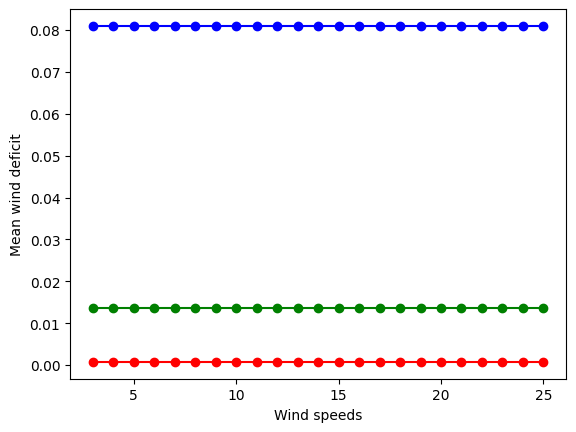

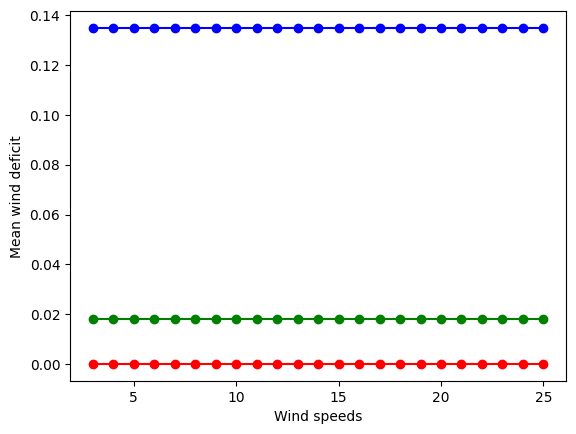

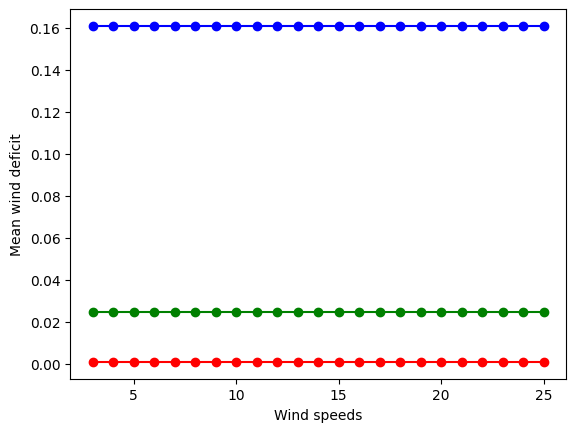

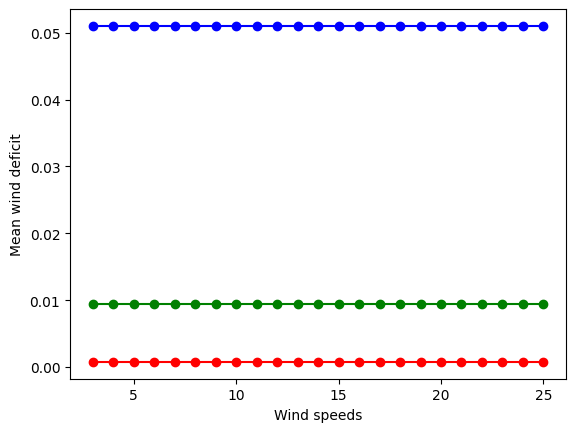

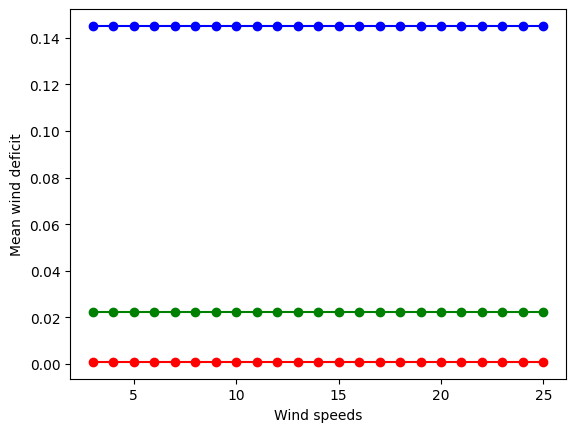

In [ ]:
import matplotlib.pyplot as plt
import random

selected_ticts = random.sample(tict_to_ws_to_deficitmetrics.items(), 5)

for tict, ws_to_deficitmean in selected_ticts:
  sorted_data = sorted(ws_to_deficitmean.items())

  # Extract sorted keys and values
  x = [key for key, _ in sorted_data]
  ys = [[value[i] for _, value in sorted_data] for i in range(3)]

  colors = ['red', 'green', 'blue']
  for i, y in enumerate(ys):
    plt.plot(x, y, marker='o', color=colors[i])
  plt.xlabel('Wind speeds')
  plt.ylabel('Mean wind deficit')
  plt.show()